In [275]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [64]:
channel_events = pd.read_csv(r'D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\OpenEphysFiles\channel_events.csv')
block1_led_off_frames = pd.read_csv(r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block1\trial1\videos\validated_off_frames.csv')
block2_led_off_frames = pd.read_csv(r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\validated_off_frames.csv')
eye_videos_led_off_frames = pd.read_csv(r'D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\eye_tracking_led_off_frames.csv')

# and this extra bit for block disambiguation

block1_frames = pd.read_csv(r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block1\trial1\videos\timestamps\19506455.csv')
block2_frames =pd.read_csv(r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\timestamps\19506455.csv')

In [106]:
def get_frame_timeseries(df,channel):
    index_range = range(0,len(df[channel][df[channel].notna()]))
    timeseries = pd.Series(df[channel][df[channel].notna()])
    timeseries = pd.Series(timeseries.values, index=index_range, name=channel)
    return timeseries

In [ ]:
def get_frame_from_time(vid_timeseries, timestamp):
    array = np.abs((vid_timeseries.to_numpy())-timestamp)
    index_of_lowest_diff = np.argmin(array)
    accuracy = abs(vid_timeseries[index_of_lowest_diff] - timestamp)
    return index_of_lowest_diff, accuracy


In [112]:
ts_list = []
for chan in list(channel_events.columns)[1:5]:
    ts = get_frame_timeseries(channel_events,str(chan))
    ts_list.append(ts)
ts_list.pop(2)
ts_list

[0          16.309200
 1          16.320168
 2          16.336666
 3          16.355734
 4          16.370068
             ...     
 58804    1010.219177
 58805    1010.235718
 58806    1010.257751
 58807    1010.269226
 58808    1010.285706
 Name: L_eye_TTL, Length: 58809, dtype: float64,
 0           4.181233
 1           4.198267
 2           4.215267
 3           4.232300
 4           4.249333
             ...     
 62581    1069.493530
 62582    1069.510498
 62583    1069.527588
 62584    1069.544556
 62585    1069.561646
 Name: Arena_TTL, Length: 62586, dtype: float64,
 0          16.307766
 1          16.317467
 2          16.334101
 3          16.353167
 4          16.367332
             ...     
 57021    1010.218689
 57022    1010.234924
 57023    1010.253845
 57024    1010.268005
 57025    1010.284668
 Name: R_eye_TTL, Length: 57026, dtype: float64]

In [214]:
anchor_vid = ts_list[0].to_numpy()
synchronized_TTLs = []
synchronization_accuracy = []
for frame in range(len(anchor_vid)):
    time = anchor_vid[frame]
    if frame % 50 == 0:
        print(f'frame {frame} out of {len(anchor_vid)}',end='\r', flush=True)
    sync_frame = []
    sync_accuracy = []
    for vid in ts_list:
        f , a = get_frame_from_time(vid,time)
        sync_frame.append(f)
        sync_accuracy.append(a)
    synchronized_TTLs.append(sync_frame)
    synchronization_accuracy.append(sync_accuracy)

In [147]:
def frame_by_frame_video_viewer(vidpath, frames_of_interest):
    cap = cv2.VideoCapture(vidpath)
    breaker = 0
    i = 0
    while breaker == 0:
        if i == len(frames_of_interest):
            breaker = 1
        if breaker == 1:
            break
        f = frames_of_interest[i]
        cap.set(cv2.CAP_PROP_POS_FRAMES, f)
        ret, frame = cap.read()
        frame = cv2.putText(frame, f'frame number {str(f)}', (30, 100), 1, 1, (255, 255, 0), 3)
        cv2.imshow('validation', frame)
        key = []
        while key not in [ord('q'), ord('k'), ord('s'), ord('b'), ord('z'), ord('x')]:
            key = cv2.waitKey(0)
            if key == ord('q'):
                breaker = 1
                break
            elif key == ord('k'):
                i += 1
                break
            elif key == ord('s'):
                i+=1
                break
            elif key == ord('b'):
                i = i - 1
                break
            elif key == ord('z'):
                if i != 0:
                    frames_of_interest [i] = frames_of_interest [i] - 1
                break
            elif key == ord('x'):
                if i != len(frames_of_interest )-1:
                    frames_of_interest [i] = frames_of_interest [i] + 1
                break
    cap.release()
    cv2.destroyAllWindows()

In [176]:
vidname = r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block1\trial1\videos\realtime_20201230T182309.mp4'
inspection_list = list(range(2050,2150))
frame_by_frame_video_viewer(vidname,inspection_list)

In [285]:
frame_array = np.array(synchronized_TTLs)
frame_array[:,1] = frame_array[:,1] + 1109 #
frame_array[:]


array([[    0,  1821,     0],
       [    1,  1822,     1],
       [    2,  1823,     2],
       ...,
       [58806, 60210, 57023],
       [58807, 60211, 57024],
       [58808, 60212, 57025]], dtype=int64)

In [207]:
def compare_times(frames):
    """
    :param frames: should be a list with three frame numbers
    :return: timestamps of the relevent frames in the different videos
    """
    timestamps = []
    for frame in range(len(frames)):
        time = ts_list[frame][frames[frame]]
        timestamps.append(time)
    return timestamps

In [ ]:
def disp_multiple_vids():
    names = [r'D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\Trial_3_L\AzulaTrial5_30_12L.mp4',
             r'D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\Trial_3_R\AzulaTrial5_30_12.mp4',
             r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\back_20201230T183223.mp4',
             r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\left_20201230T183223.mp4'];
    window_titles = ['first', 'second', 'third', 'fourth']


    cap = [cv2.VideoCapture(i) for i in names]

    frames = [None] * len(names);
    gray = [None] * len(names);
    ret = [None] * len(names);

    while True:

        for i,c in enumerate(cap):
            if c is not None:
                ret[i], frames[i] = c.read();


        for i,f in enumerate(frames):
            if ret[i] is True:
                gray[i] = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
                cv2.imshow(window_titles[i], gray[i]);

        if cv2.waitKey(1) & 0xFF == ord('q'):
           break


    for c in cap:
        if c is not None:
            c.release();

    cv2.destroyAllWindows()

In [253]:
print(compare_times(synchronized_TTLs[0]))
print(synchronized_TTLs[0])

[16.309200286865234, 16.301567077636722, 16.30776596069336]
[0, 712, 0]


In [228]:
last_frame_block1 = len(block1_frames) - 1109

# which means that block 1 end on the
last_frame_block1

30574

In [246]:
sync_block1 = np.array(synchronized_TTLs)
sync_block1[:,1] = sync_block1[:,1]+1109
sync_block1 = sync_block1[0:last_frame_block1]
sync_block1

array([[    0,  1821,     0],
       [    1,  1822,     1],
       [    2,  1823,     2],
       ...,
       [30571, 32085, 29643],
       [30572, 32086, 29644],
       [30573, 32087, 29645]], dtype=int64)

In [272]:
block1_ts = pd.Series(ts_list[1].to_numpy()[0:len(block1_frames)-1109], index=range(1109,31683), name='Block1 frame-timestamp')
left_eye_b1_series = pd.Series(ts_list[0][0:len(block1_ts)], index=sync_block1[:,0])
right_eye_b1_series = pd.Series(ts_list[2][0:len(block1_ts)], index=sync_block1[:,2])
block1_ts.to_csv(r'D:\AzulaTrials_30_12_2020\Analysis_Results\Trial3\arena_block1.csv')
left_eye_b1_series.to_csv(r'D:\AzulaTrials_30_12_2020\Analysis_Results\Trial3\left_eye_block1.csv')
right_eye_b1_series.to_csv(r'D:\AzulaTrials_30_12_2020\Analysis_Results\Trial3\right_eye_block1.csv')

In [274]:
df = pd.DataFrame(sync_block1)
df.to_csv(r'D:\AzulaTrials_30_12_2020\Analysis_Results\Trial3\frame_sync.csv')

In [289]:
SA = np.array(synchronization_accuracy)
SA[:,0]

array([0., 0., 0., ..., 0., 0., 0.])

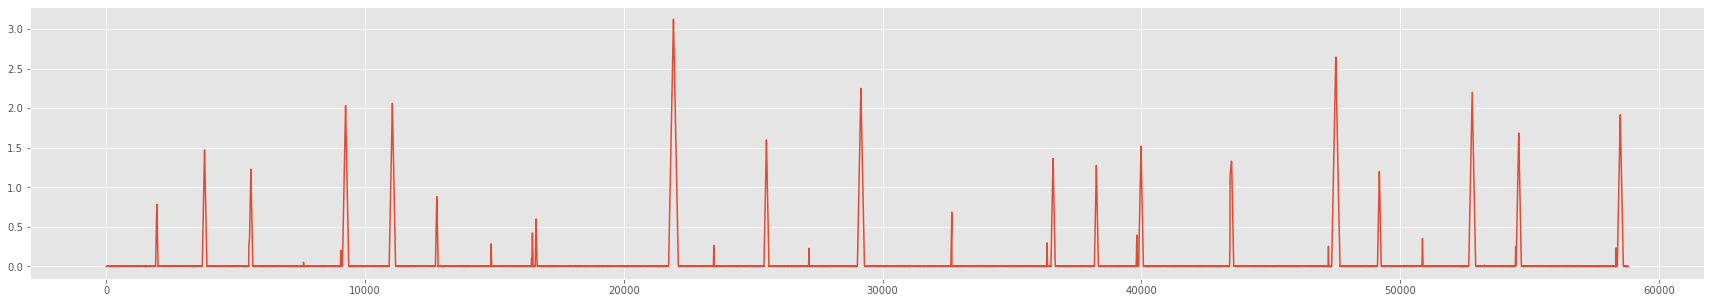

In [298]:
f = plt.figure(figsize=(30,5))
plt.plot(SA[:,2])



In [ ]:
def TTL_timeseries_synchronization(ts_list,anchor_vid_position):
    """
    param: ts_list: list of timeseries (one for each video) representing rising edge events in the open ephys file
    param: anchor_vid_position: the video from the ts_list to use as a sync reference (all other video frames will be fitted to this video)
    returns: synchronized_TTLs: np.array where each column represents a video and each row represents the best fit for the anchor video frames (timewise)
    """

    anchor_vid = ts_list[anchor_vid_position].to_numpy()
    synchronized_TTLs = []
    synchronization_accuracy = []
    for frame in range(len(anchor_vid)):
        time = anchor_vid[frame]
        if frame % 50 == 0:
            print(f'frame {frame} out of {len(anchor_vid)}',end='\r', flush=True)
        sync_frame = []
        sync_accuracy = []
        for vid in ts_list:
            f , a = get_frame_from_time(vid,time)
            sync_frame.append(f)
            sync_accuracy.append(a)
        synchronized_TTLs.append(sync_frame)
        synchronization_accuracy.append(sync_accuracy)
    synchronized_TTLs = np.array(synchronized_TTLs)
    synchronization_accuracy = np.array(synchronization_accuracy)

    return synchronized_TTLs, synchronization_accuracy